# GoingDeeper2 : 멋진 단어사전 만들기

1. Rubrics
    * 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
    * SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
    * SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다

## 1.1 데이터 불러오기

In [1]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab, Hannanum, Komoran

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM

import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import konlpy
import pandas as pd
import re


print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


### 데이터 불러오기 및 이해하기

In [2]:
dir_path = "/aiffel/aiffel/aiffel/nsmc-master/"
data_path = dir_path + "ratings.txt"

In [3]:
data = pd.read_table(data_path)
data = data[['document','label']]

In [4]:
data.head(5)

,document,label
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [5]:
data.shape

(200000, 2)

In [6]:
data[data.label == 0]

,document,label
100000,이런영화로 관객들한테 돈벌고싶소?,0
100001,작품 선구안이 없다는게 배우 김태희의 최대 약점.,0
100002,사극?? 로멘스?? 퓨젼??,0
100003,ㅋㅋㅋㅋ엿국니네가그렇지므ㅝ 이건뭐 영화도아니고,0
100004,완죤유치하고 못봐주겠네...,0
...,...,...
199995,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,쓰.레.기,0
199997,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


#### remark

1. 네이버 리뷰 데이터가 총 20만 개임을 알 수 있다.

2. label은 0과 1로 구성되어 있으며 1은 긍정, 0은 부정을 의미한다.

3. 데이터의 label이 1인 것이 앞의 절반, 0인 것이 뒤의 절반으로 완전히 분리되어있다. 

## 1.2 데이터 전처리_1

1. 결측치 삭제
2. 문장 길이의 평균 기준 +- 1표준편차 만큼 데이터 삭제
    * 결과적으로 20만개 문장에서 163912 문장으로 줄어들 것

In [7]:
data[data.document.isnull()]

,document,label
46471,NaN,1
60735,NaN,1
77665,NaN,1
84098,NaN,1
127017,NaN,0
172375,NaN,0
173526,NaN,0
197279,NaN,0


In [8]:
data[data.label.isnull()]

,document,label


In [9]:
data = data.dropna(subset = ['document'])

In [10]:
data.shape

(199992, 2)

In [11]:
(data.document.nunique(), data.label.nunique())

(194543, 2)

In [12]:
data = data.drop_duplicates(subset=['document'])

In [13]:
data.groupby('label').count()

,document
label,
0,97277
1,97266


In [14]:
data.document[0:5]

0                                  어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1    디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                 폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3    와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                          안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
Name: document, dtype: object

In [15]:
def text_cleaning(text):
    
    text = re.sub("[^ 가-힣]","",text)
    text = re.sub("\s+", " ",text)
    
    return text

In [16]:
data.document = data.document.apply(text_cleaning)

In [17]:
data.document.isnull().sum()

0

In [18]:
def text_length(text):
    return len(text)

In [19]:
data["document_length"] = data.document.apply(text_length)

In [20]:
data = data[["document","document_length","label"]]

In [21]:
data.head()

,document,document_length,label
0,어릴때보고 지금다시봐도 재밌어요,17,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,134,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,32,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,48,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,26,1


In [22]:
data[data.document_length == 0]

,document,document_length,label
111,,0,1
190,,0,1
203,,0,1
984,,0,1
1199,,0,1
...,...,...,...
198033,,0,0
198364,,0,0
199271,,0,0
199321,,0,0


In [23]:
data = data.drop(data[data.document_length == 0].index)

In [24]:
data.head()

,document,document_length,label
0,어릴때보고 지금다시봐도 재밌어요,17,1
1,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,134,1
2,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,32,1
3,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,48,1
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,26,1


In [25]:
data.shape

(193891, 3)

Data Size: 193891
문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 32


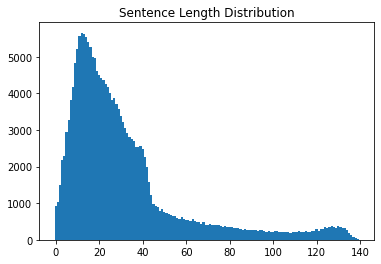

In [26]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = data.document
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

In [27]:
data.document_length.describe()

count    193891.000000
mean         32.588588
std          27.856685
min           1.000000
25%          14.000000
50%          24.000000
75%          39.000000
max         140.000000
Name: document_length, dtype: float64

In [28]:
data = data[(5<= data.document_length) & (data.document_length <= 60)]

Data Size: 163912
문장의 최단 길이: 5
문장의 최장 길이: 60
문장의 평균 길이: 24


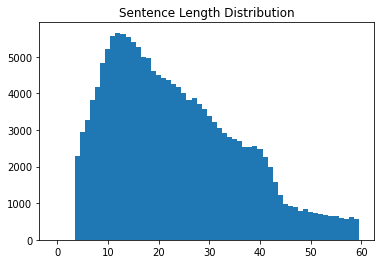

In [29]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = data.document
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title('Sentence Length Distribution')
plt.show()

## 1.3 데이터 전처리_2

1. mecab / komoran / hannanum 별로 개별 토크나이징

2. 이를 데이터프레임에 적용

3. 이후 토크나이징 할 때 등장 횟수가 4번 이하인 희귀 토큰은 단어장에 반영하지 않고 unk 토큰으로 처리할 것

In [ ]:
mecab = Mecab()
komoran = Komoran()
hannanum = Hannanum()

In [31]:
mecab_data = data.copy()
komoran_data = data.copy()
hannanum_data = data.copy()

In [32]:
def tokenize_pre(corpus, vocab_size=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words = vocab_size)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, tokenizer

In [33]:
def tokenize_post(corpus, vocab_size=None):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words = vocab_size)
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, tokenizer

In [34]:
def mecab_split(text):
    return mecab.morphs(text)

def komoran_split(text):
    return komoran.morphs(text)

def hannanum_split(text):
    return hannanum.morphs(text)

In [35]:
print(mecab_split("나에게는 꿈이 있습니다"))
print(komoran_split("나에게는 꿈이 있습니다"))
print(hannanum_split("나에게는 꿈이 있습니다"))

['나', '에게', '는', '꿈', '이', '있', '습니다']
['나', '에게', '는', '꿈', '이', '있', '습니다']
['나', '에게는', '꿈', '이', '있', '습니다']


In [36]:
mecab_data["mecab_corpus"] = mecab_data.document.apply(mecab_split)
komoran_data["komoran_corpus"] = komoran_data.document.apply(komoran_split)
hannanum_data["hannanum_corpus"] = hannanum_data.document.apply(hannanum_split)

java.lang.ArrayIndexOutOfBoundsException: Index 10000 out of bounds for length 10000
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.PosTagger.HmmPosTagger.HMMTagger.new_mnode(HMMTagger.java:354)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.PosTagger.HmmPosTagger.HMMTagger.tagPOS(HMMTagger.java:143)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyzeInSingleThread(Workflow.java:857)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyze(Workflow.java:521)
	at kr.lucypark.jhannanum.comm.HannanumInterface.simplePos09(Unknown Source)


In [37]:
mecab_data.tail()

,document,document_length,label,mecab_corpus
199994,개연성이 없어요 별루다,12,0,"[개연, 성, 이, 없, 어요, 별루, 다]"
199995,포켓 몬스터 짜가,10,0,"[포켓, 몬스터, 짜, 가]"
199997,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,31,0,"[완전, 사이코, 영화, 마지막, 은, 더욱더, 이, 영화, 의, 질, 을, 떨어트..."
199998,왜난 재미없었지 라따뚜이 보고나서 스머프 봐서 그런가,30,0,"[왜, 난, 재미없, 었, 지, 라따뚜이, 보, 고, 나, 서, 스머프, 봐서, 그런가]"
199999,포풍저그가나가신다영차영차영차,15,0,"[포, 풍, 저그, 가, 나가, 신다, 영차영차, 영차]"


In [38]:
mecab_result = []

for i, x in zip(mecab_data.index, mecab_data.mecab_corpus):
    if len(x) == 0:
        mecab_result.append(i)

In [39]:
komoran_result = []

for i, x in zip(komoran_data.index, komoran_data.komoran_corpus):
    if len(x) == 0:
        komoran_result.append(i)

In [40]:
hannanum_result = []

for i, x in zip(hannanum_data.index, hannanum_data.hannanum_corpus):
    if len(x) == 0:
        hannanum_result.append(i)

In [41]:
print(mecab_result, len(mecab_result), sep="\n")
print(komoran_result, len(komoran_result), sep="\n")
print(hannanum_result, len(hannanum_result), sep="\n")

[]
0
[]
0
[25647]
1


In [42]:
result = list((set(mecab_result) | set(komoran_result)) | set(hannanum_result))

In [43]:
mecab_data = mecab_data.drop(result)
komoran_data = komoran_data.drop(result)
hannanum_data = hannanum_data.drop(result)

In [44]:
data = data.loc[mecab_data.index]

In [45]:
mecab_tensor_pre, mecab_tokenizer_pre = tokenize_pre(mecab_data.mecab_corpus)
mecab_tensor_post, mecab_tokenizer_post = tokenize_post(mecab_data.mecab_corpus)

komoran_tensor_pre, komoran_tokenizer_pre = tokenize_pre(komoran_data.komoran_corpus)
komoran_tensor_post, komoran_tokenizer_post = tokenize_post(komoran_data.komoran_corpus)

hannanum_tensor_pre, hannanum_tokenizer_pre = tokenize_pre(hannanum_data.hannanum_corpus)
hannanum_tensor_post, hannanum_tokenizer_post = tokenize_post(hannanum_data.hannanum_corpus)

In [46]:
threshold = 5
total_cnt = len(mecab_tokenizer_post.word_index)
rare_cnt = 0

total_freq = 0
rare_freq = 0


for key, value in mecab_tokenizer_post.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
print('mecab 단어 집합(vocabulary)의 크기 :',total_cnt)
print('mecab tensoor 중 등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print("mecab 단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100,3),"%")
print("mecab 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100,3),"%")

mecab 단어 집합(vocabulary)의 크기 : 44018
mecab tensoor 중 등장 빈도가 4번 이하인 희귀 단어의 수: 30415
mecab 단어 집합에서 희귀 단어의 비율: 69.097 %
mecab 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.489 %


In [47]:
mecab_vocab_size = total_cnt - rare_cnt + 1
print("단어장의 크기: ", mecab_vocab_size)

단어장의 크기:  13604


In [48]:
threshold = 5
total_cnt = len(komoran_tokenizer_post.word_index)
rare_cnt = 0

total_freq = 0
rare_freq = 0


for key, value in komoran_tokenizer_post.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
print('komoran 단어 집합(vocabulary)의 크기 :',total_cnt)
print('komoran tensoor 중 등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print("komoran 단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100,3),"%")
print("komoran 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100,3),"%")

komoran 단어 집합(vocabulary)의 크기 : 39539
komoran tensoor 중 등장 빈도가 4번 이하인 희귀 단어의 수: 27843
komoran 단어 집합에서 희귀 단어의 비율: 70.419 %
komoran 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.94 %


In [49]:
komoran_vocab_size = total_cnt - rare_cnt + 1
print("단어장의 크기: ", komoran_vocab_size)

단어장의 크기:  11697


In [50]:
threshold = 5
total_cnt = len(hannanum_tokenizer_post.word_index)
rare_cnt = 0

total_freq = 0
rare_freq = 0

for key, value in hannanum_tokenizer_post.word_counts.items():
    total_freq += value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
print('hannanum 단어 집합(vocabulary)의 크기 :',total_cnt)
print('hannanum tensoor 중 등장 빈도가 {}번 이하인 희귀 단어의 수: {}'.format(threshold - 1, rare_cnt))
print("hannanum 단어 집합에서 희귀 단어의 비율:", round((rare_cnt / total_cnt)*100,3),"%")
print("hannanum 전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", round((rare_freq / total_freq)*100,3),"%")

hannanum 단어 집합(vocabulary)의 크기 : 147929
hannanum tensoor 중 등장 빈도가 4번 이하인 희귀 단어의 수: 135174
hannanum 단어 집합에서 희귀 단어의 비율: 91.378 %
hannanum 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.306 %


In [51]:
hannanum_vocab_size = total_cnt - rare_cnt + 1
print("단어장의 크기: ", hannanum_vocab_size)

단어장의 크기:  12756


In [52]:
mecab_tensor_pre, mecab_tokenizer_pre = tokenize_pre(mecab_data.mecab_corpus, vocab_size = 12000)
mecab_tensor_post, mecab_tokenizer_post = tokenize_post(mecab_data.mecab_corpus, vocab_size = 12000)

komoran_tensor_pre, komoran_tokenizer_pre = tokenize_pre(komoran_data.komoran_corpus, vocab_size = 12000)
komoran_tensor_post, komoran_tokenizer_post = tokenize_post(komoran_data.komoran_corpus, vocab_size = 12000)

hannanum_tensor_pre, hannanum_tokenizer_pre = tokenize_pre(hannanum_data.hannanum_corpus, vocab_size = 12000)
hannanum_tensor_post, hannanum_tokenizer_post = tokenize_post(hannanum_data.hannanum_corpus, vocab_size = 12000)

#### remark

1. 5번 이상인 단어의 집합이 전체적으로 11000에서 13000 사이로 나오고 있어서 vocab size를 12000으로 잡았다.

2. 이를 기준으로 sentence piece tokenizer의 단어장 사이즈도 12000으로 잡을 예정

# 2. 모델링

## 2.1 sentence piece 토크나이저 학습

1. sentence piece 토크나이저는 비지도학습 토크나이저이므로 학습의 과정이 필요하다.
2. vocab size는 위에서 언급한 것처럼 12000으로 잡을 것이다.

In [53]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [54]:
with open("naver_review.text", 'w') as f:
    for x in data.document:
        f.write(x+"\n")

In [55]:
import sentencepiece as spm
import os
vocab_size = 12000    

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format("naver_review.text", vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=naver_review.text --model_prefix=naver_review_spm --vocab_size=12000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: naver_review.text
  input_format: 
  model_prefix: naver_review_spm
  model_type: UNIGRAM
  vocab_size: 12000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_p

In [56]:
!ls -l naver_review_spm*

-rw-r--r-- 1 root root 458613 Feb 16 17:30 naver_review_spm.model
-rw-r--r-- 1 root root 231738 Feb 16 17:30 naver_review_spm.vocab


In [57]:
vocab_list = pd.read_csv('naver_review_spm.vocab', sep='\t', header=None)

In [58]:
vocab_list

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.58923
4,▁영화,-4.21357
...,...,...
11995,랐,-14.89490
11996,떻,-14.89500
11997,잊,-14.89510
11998,깊,-14.89520


In [59]:
s = spm.SentencePieceProcessor()
s.Load('naver_review_spm.model')

True

In [60]:
def sp_tokenize_pre(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [61]:
def sp_tokenize_post(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_review_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [62]:
sp_tensor_pre, sp_word_index_pre, sp_index_word_pre = sp_tokenize_pre(s, data.document)
sp_tensor_post,sp_word_index_post, sp_index_word_post = sp_tokenize_post(s, data.document)

## 2.2 학습

1. train : val : test = 0.5625 : 0.1875 : 0.25
2. 임베딩 차원은 100
3. lstm 차원은 128
4. 각 토크나이저 별로 pre padding과 post padding의 성능 차이를 비교할 것이다.
5. 따라서 4개의 토크나이저를 2개의 padding 별로 학습해야 해서 총 8번의 학습이 이뤄질 것이다.

### 2.2.1 mecab - pre

In [63]:
x_train, x_test, y_train, y_test = train_test_split(mecab_tensor_pre, 
                                                    mecab_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [64]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [65]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

mecab_pre_model = keras.Model(inputs, outputs)

In [66]:
mecab_pre_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1200000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [67]:
mecab_pre_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

mecab_pre_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/mecab_pre_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [68]:
history =mecab_pre_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, mecab_pre_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 12s 27ms/step - loss: 0.4486 - accuracy: 0.7903 - val_loss: 0.3727 - val_accuracy: 0.8336

Epoch 00001: val_accuracy improved from -inf to 0.83357, saving model to /aiffel/aiffel/aiffel/mecab_pre_model.h5
Epoch 2/50
181/181 [==============================] - 3s 19ms/step - loss: 0.3421 - accuracy: 0.8527 - val_loss: 0.3678 - val_accuracy: 0.8380

Epoch 00002: val_accuracy improved from 0.83357 to 0.83800, saving model to /aiffel/aiffel/aiffel/mecab_pre_model.h5
Epoch 3/50
181/181 [==============================] - 3s 19ms/step - loss: 0.3167 - accuracy: 0.8646 - val_loss: 0.3643 - val_accuracy: 0.8431

Epoch 00003: val_accuracy improved from 0.83800 to 0.84314, saving model to /aiffel/aiffel/aiffel/mecab_pre_model.h5
Epoch 4/50
181/181 [==============================] - 3s 19ms/step - loss: 0.2961 - accuracy: 0.8750 - val_loss: 0.3586 - val_accuracy: 0.8434

Epoch 00004: val_accuracy improved from 0.84314 to 0.84337, saving model to

In [69]:
mecab_pre_loaded_model = load_model('/aiffel/aiffel/aiffel/mecab_pre_model.h5')
print("테스트 정확도: {}".format(mecab_pre_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 7s 4ms/step - loss: 0.3546 - accuracy: 0.8502
테스트 정확도: 0.8501878976821899


### 2.2.2 mecab - post

In [70]:
x_train, x_test, y_train, y_test = train_test_split(mecab_tensor_post, 
                                                    mecab_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [71]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [72]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

mecab_post_model = keras.Model(inputs, outputs)

In [73]:
mecab_post_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [74]:
mecab_post_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

mecab_post_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/mecab_post_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [75]:
history =mecab_post_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, mecab_post_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 10s 27ms/step - loss: 0.4391 - accuracy: 0.7926 - val_loss: 0.4019 - val_accuracy: 0.8232

Epoch 00001: val_accuracy improved from -inf to 0.82323, saving model to /aiffel/aiffel/aiffel/mecab_post_model.h5
Epoch 2/50
181/181 [==============================] - 3s 19ms/step - loss: 0.3438 - accuracy: 0.8526 - val_loss: 0.3828 - val_accuracy: 0.8344

Epoch 00002: val_accuracy improved from 0.82323 to 0.83439, saving model to /aiffel/aiffel/aiffel/mecab_post_model.h5
Epoch 3/50
181/181 [==============================] - 3s 19ms/step - loss: 0.3178 - accuracy: 0.8653 - val_loss: 0.3685 - val_accuracy: 0.8446

Epoch 00003: val_accuracy improved from 0.83439 to 0.84463, saving model to /aiffel/aiffel/aiffel/mecab_post_model.h5
Epoch 4/50
181/181 [==============================] - 3s 19ms/step - loss: 0.2961 - accuracy: 0.8745 - val_loss: 0.3614 - val_accuracy: 0.8481

Epoch 00004: val_accuracy improved from 0.84463 to 0.84808, saving model

In [76]:
mecab_post_loaded_model = load_model('/aiffel/aiffel/aiffel/mecab_post_model.h5')
print("테스트 정확도: {}".format(mecab_post_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 6s 4ms/step - loss: 0.3412 - accuracy: 0.8520
테스트 정확도: 0.85199373960495


### 2.2.3 komoran - pre

In [77]:
x_train, x_test, y_train, y_test = train_test_split(komoran_tensor_pre, 
                                                    komoran_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [78]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [79]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

komoran_pre_model = keras.Model(inputs, outputs)

In [80]:
komoran_pre_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [81]:
komoran_pre_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

komoran_pre_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/komoran_pre_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [82]:
history =komoran_pre_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, komoran_pre_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 15s 41ms/step - loss: 0.4649 - accuracy: 0.7824 - val_loss: 0.3823 - val_accuracy: 0.8298

Epoch 00001: val_accuracy improved from -inf to 0.82977, saving model to /aiffel/aiffel/aiffel/komoran_pre_model.h5
Epoch 2/50
181/181 [==============================] - 4s 22ms/step - loss: 0.3574 - accuracy: 0.8446 - val_loss: 0.3826 - val_accuracy: 0.8306

Epoch 00002: val_accuracy improved from 0.82977 to 0.83064, saving model to /aiffel/aiffel/aiffel/komoran_pre_model.h5
Epoch 3/50
181/181 [==============================] - 4s 22ms/step - loss: 0.3340 - accuracy: 0.8555 - val_loss: 0.3792 - val_accuracy: 0.8388

Epoch 00003: val_accuracy improved from 0.83064 to 0.83878, saving model to /aiffel/aiffel/aiffel/komoran_pre_model.h5
Epoch 4/50
181/181 [==============================] - 4s 22ms/step - loss: 0.3133 - accuracy: 0.8657 - val_loss: 0.3478 - val_accuracy: 0.8441

Epoch 00004: val_accuracy improved from 0.83878 to 0.84411, saving mo

In [83]:
komoran_pre_loaded_model = load_model('/aiffel/aiffel/aiffel/komoran_pre_model.h5')
print("테스트 정확도: {}".format(komoran_pre_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 6s 4ms/step - loss: 0.3611 - accuracy: 0.8461
테스트 정확도: 0.8460637331008911


### 2.2.4 komoran - post

In [84]:
x_train, x_test, y_train, y_test = train_test_split(komoran_tensor_post, 
                                                    komoran_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [85]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [86]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

komoran_post_model = keras.Model(inputs, outputs)

In [87]:
komoran_post_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [88]:
komoran_post_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

komoran_post_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/komoran_post_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [89]:
history =komoran_post_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, komoran_post_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 12s 31ms/step - loss: 0.4507 - accuracy: 0.7850 - val_loss: 0.3988 - val_accuracy: 0.8307

Epoch 00001: val_accuracy improved from -inf to 0.83071, saving model to /aiffel/aiffel/aiffel/komoran_post_model.h5
Epoch 2/50
181/181 [==============================] - 4s 23ms/step - loss: 0.3619 - accuracy: 0.8412 - val_loss: 0.3841 - val_accuracy: 0.8272

Epoch 00002: val_accuracy did not improve from 0.83071
Epoch 3/50
181/181 [==============================] - 4s 23ms/step - loss: 0.3341 - accuracy: 0.8550 - val_loss: 0.4309 - val_accuracy: 0.8236

Epoch 00003: val_accuracy did not improve from 0.83071
Epoch 4/50
181/181 [==============================] - 4s 23ms/step - loss: 0.3138 - accuracy: 0.8645 - val_loss: 0.3660 - val_accuracy: 0.8360

Epoch 00004: val_accuracy improved from 0.83071 to 0.83598, saving model to /aiffel/aiffel/aiffel/komoran_post_model.h5
Epoch 5/50
181/181 [==============================] - 4s 23ms/step - loss: 0

In [90]:
komoran_post_loaded_model = load_model('/aiffel/aiffel/aiffel/komoran_post_model.h5')
print("테스트 정확도: {}".format(komoran_post_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 6s 4ms/step - loss: 0.3904 - accuracy: 0.8462
테스트 정확도: 0.8461613655090332


### 2.2.5 hannanum - pre

In [91]:
x_train, x_test, y_train, y_test = train_test_split(hannanum_tensor_pre, 
                                                    hannanum_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [92]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [93]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

hannanum_pre_model = keras.Model(inputs, outputs)

In [94]:
hannanum_pre_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [95]:
hannanum_pre_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

hannanum_pre_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/hannanum_pre_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [96]:
history =hannanum_pre_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, hannanum_pre_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 10s 29ms/step - loss: 0.4992 - accuracy: 0.7451 - val_loss: 0.4361 - val_accuracy: 0.7872

Epoch 00001: val_accuracy improved from -inf to 0.78724, saving model to /aiffel/aiffel/aiffel/hannanum_pre_model.h5
Epoch 2/50
181/181 [==============================] - 4s 21ms/step - loss: 0.4016 - accuracy: 0.8123 - val_loss: 0.4195 - val_accuracy: 0.8031

Epoch 00002: val_accuracy improved from 0.78724 to 0.80312, saving model to /aiffel/aiffel/aiffel/hannanum_pre_model.h5
Epoch 3/50
181/181 [==============================] - 4s 21ms/step - loss: 0.3788 - accuracy: 0.8241 - val_loss: 0.4280 - val_accuracy: 0.7949

Epoch 00003: val_accuracy did not improve from 0.80312
Epoch 4/50
181/181 [==============================] - 4s 21ms/step - loss: 0.3618 - accuracy: 0.8327 - val_loss: 0.4066 - val_accuracy: 0.8056

Epoch 00004: val_accuracy improved from 0.80312 to 0.80559, saving model to /aiffel/aiffel/aiffel/hannanum_pre_model.h5
Epoch 5/50


In [97]:
hannanum_pre_loaded_model = load_model('/aiffel/aiffel/aiffel/hannanum_pre_model.h5')
print("테스트 정확도: {}".format(hannanum_pre_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 5s 4ms/step - loss: 0.4401 - accuracy: 0.8104
테스트 정확도: 0.8103616833686829


### 2.2.6 hannanum - post

In [98]:
x_train, x_test, y_train, y_test = train_test_split(hannanum_tensor_post, 
                                                    hannanum_data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [99]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [100]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

hannanum_post_model = keras.Model(inputs, outputs)

In [101]:
hannanum_post_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [102]:
hannanum_post_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

hannanum_post_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/hannanum_post_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [103]:
history =hannanum_post_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, hannanum_post_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 11s 30ms/step - loss: 0.4975 - accuracy: 0.7475 - val_loss: 0.4315 - val_accuracy: 0.7950

Epoch 00001: val_accuracy improved from -inf to 0.79498, saving model to /aiffel/aiffel/aiffel/hannanum_post_model.h5
Epoch 2/50
181/181 [==============================] - 4s 21ms/step - loss: 0.3993 - accuracy: 0.8143 - val_loss: 0.4393 - val_accuracy: 0.7904

Epoch 00002: val_accuracy did not improve from 0.79498
Epoch 3/50
181/181 [==============================] - 4s 21ms/step - loss: 0.3762 - accuracy: 0.8255 - val_loss: 0.4140 - val_accuracy: 0.8059

Epoch 00003: val_accuracy improved from 0.79498 to 0.80592, saving model to /aiffel/aiffel/aiffel/hannanum_post_model.h5
Epoch 4/50
181/181 [==============================] - 4s 21ms/step - loss: 0.3600 - accuracy: 0.8343 - val_loss: 0.4080 - val_accuracy: 0.8042

Epoch 00004: val_accuracy did not improve from 0.80592
Epoch 5/50
181/181 [==============================] - 4s 21ms/step - loss:

In [104]:
hannanum_post_loaded_model = load_model('/aiffel/aiffel/aiffel/hannanum_post_model.h5')
print("테스트 정확도: {}".format(hannanum_post_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 6s 4ms/step - loss: 0.4008 - accuracy: 0.8087
테스트 정확도: 0.8086778521537781


### 2.2.7 Sentencepiece - pre

In [105]:
x_train, x_test, y_train, y_test = train_test_split(sp_tensor_pre, 
                                                    data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [106]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [107]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

sp_pre_model = keras.Model(inputs, outputs)

In [108]:
sp_pre_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [109]:
sp_pre_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

sp_pre_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/sp_pre_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [110]:
history =sp_pre_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, sp_pre_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 14s 38ms/step - loss: 0.4611 - accuracy: 0.7831 - val_loss: 0.3896 - val_accuracy: 0.8212

Epoch 00001: val_accuracy improved from -inf to 0.82124, saving model to /aiffel/aiffel/aiffel/sp_pre_model.h5
Epoch 2/50
181/181 [==============================] - 4s 23ms/step - loss: 0.3351 - accuracy: 0.8565 - val_loss: 0.3518 - val_accuracy: 0.8451

Epoch 00002: val_accuracy improved from 0.82124 to 0.84506, saving model to /aiffel/aiffel/aiffel/sp_pre_model.h5
Epoch 3/50
181/181 [==============================] - 4s 23ms/step - loss: 0.3065 - accuracy: 0.8696 - val_loss: 0.3745 - val_accuracy: 0.8445

Epoch 00003: val_accuracy did not improve from 0.84506
Epoch 4/50
181/181 [==============================] - 4s 24ms/step - loss: 0.2878 - accuracy: 0.8788 - val_loss: 0.3553 - val_accuracy: 0.8486

Epoch 00004: val_accuracy improved from 0.84506 to 0.84864, saving model to /aiffel/aiffel/aiffel/sp_pre_model.h5
Epoch 5/50
181/181 [=========

In [111]:
sp_pre_loaded_model = load_model('/aiffel/aiffel/aiffel/sp_pre_model.h5')
print("테스트 정확도: {}".format(sp_pre_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 6s 4ms/step - loss: 0.4230 - accuracy: 0.8449
테스트 정확도: 0.8449411988258362


### 2.2.8 Sentencepiece - post

In [112]:
x_train, x_test, y_train, y_test = train_test_split(sp_tensor_post, 
                                                    data.label, 
                                                    test_size=0.25,
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [113]:
print(len(x_train),len(y_train),sep="\n")
print(len(x_val),len(y_val),sep="\n")
print(len(x_test),len(y_test),sep="\n")

92199
92199
30734
30734
40978
40978


In [114]:
word_vector_dim = 100
hidden_units = 128

inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(input_dim = vocab_size, 
                            output_dim = word_vector_dim)(inputs)
x = layers.LSTM(128, return_sequences=True)(embedded)
x = layers.LSTM(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

sp_post_model = keras.Model(inputs, outputs)

In [115]:
sp_post_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 100)         1200000   
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 128)         117248    
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,448,961
Trainable params: 1,448,961
Non-trainable params: 0
_________________________________________________________________


In [116]:
sp_post_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 50
batch_size = 64
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

sp_post_model_mc = ModelCheckpoint('/aiffel/aiffel/aiffel/sp_post_model.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [117]:
history =sp_post_model.fit(x_train,
                             y_train, 
                             epochs=epochs, 
                             batch_size=512, 
                             validation_data=(x_val, y_val),
                             callbacks=[es, sp_post_model_mc],
                             verbose=1)

Epoch 1/50
181/181 [==============================] - 14s 33ms/step - loss: 0.5895 - accuracy: 0.6603 - val_loss: 0.4008 - val_accuracy: 0.8265

Epoch 00001: val_accuracy improved from -inf to 0.82651, saving model to /aiffel/aiffel/aiffel/sp_post_model.h5
Epoch 2/50
181/181 [==============================] - 4s 24ms/step - loss: 0.3862 - accuracy: 0.8378 - val_loss: 0.3997 - val_accuracy: 0.8185

Epoch 00002: val_accuracy did not improve from 0.82651
Epoch 3/50
181/181 [==============================] - 4s 24ms/step - loss: 0.3446 - accuracy: 0.8570 - val_loss: 0.3841 - val_accuracy: 0.8233

Epoch 00003: val_accuracy did not improve from 0.82651
Epoch 4/50
181/181 [==============================] - 4s 24ms/step - loss: 0.3198 - accuracy: 0.8675 - val_loss: 0.3718 - val_accuracy: 0.8433

Epoch 00004: val_accuracy improved from 0.82651 to 0.84330, saving model to /aiffel/aiffel/aiffel/sp_post_model.h5
Epoch 5/50
181/181 [==============================] - 4s 24ms/step - loss: 0.3007 - ac

In [118]:
sp_post_loaded_model = load_model('/aiffel/aiffel/aiffel/sp_post_model.h5')
print("테스트 정확도: {}".format(sp_post_loaded_model.evaluate(x_test, y_test)[1]))

1281/1281 [==============================] - 7s 4ms/step - loss: 0.3720 - accuracy: 0.8458
테스트 정확도: 0.8458440899848938


# 3. 결과 분석

1. pre와 post 패딩의 유의미한 차이는 보이지 않았다.

2. Hannanum은 80%의 accuracy, 나머지는 83~84%의 accuracy를 보였다.